In [1]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Model

def vgg16_model(trainable=True):
    base_model = VGG16(False, weights="imagenet")
    for layer in base_model.layers:
        layer.trainable = True
    
    last_conv_layer = base_model.get_layer("block5_conv3")
    x = GlobalAveragePooling2D()(last_conv_layer.output)
    x = Dense(512, activation="relu")(x)  
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.25)(x)
    predictions = Dense(1, activation="sigmoid")(x)
    return Model(base_model.input, predictions)



model = vgg16_model(False)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [2]:
from ProjectPaths import ProjectPaths
import numpy as np
import os

In [3]:
heerlen_images_filename = os.path.join(ProjectPaths.instance().image_dir, "deepsolaris_heerlen.npy")
heerlen_labels_filename = os.path.join(ProjectPaths.instance().image_dir, "deepsolaris_heerlen_labels.npy")

In [9]:
heerlen_images = np.load(heerlen_images_filename)
heerlen_labels = np.load(heerlen_labels_filename)
heerlen_labels.shape

(15540,)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

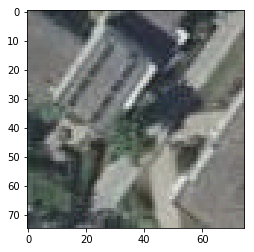

In [6]:
plt.imshow(heerlen_images[0][:,:,::-1])

In [7]:
heerlen_images_normalized = heerlen_images / 255
heerlen_images_normalized.shape, heerlen_images.min(), heerlen_images.max()

((15540, 75, 75, 3), 0, 255)

In [28]:
from sklearn.model_selection import train_test_split

train_images, test_validation_images, train_labels, test_validation_labels = train_test_split(heerlen_images_normalized, heerlen_labels, test_size=0.20)
test_images, validation_images, test_labels, validation_labels = train_test_split(test_validation_images, test_validation_labels, test_size=0.50)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range = 0.1,
    zoom_range = 0.3,
    shear_range = 0.15,                                
    #brightness_range = [0.9, 1.1],
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator()

In [13]:
from keras.optimizers import SGD

batch_size = 64
epochs = 100
learning_rate = 0.0001
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [14]:
train_generator = data_generator.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size, shuffle=False)

In [15]:
from PerformanceMetrics import PerformanceMetrics

model.compile(optimizer="adadelta", loss='binary_crossentropy',
                  metrics=['accuracy', PerformanceMetrics.precision,
                           PerformanceMetrics.recall, PerformanceMetrics.fmeasure])

In [17]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping




model_name = "vgg16_heerlen_batch_norm"

checkpoint_dir = ProjectPaths.instance().checkpoint_dir_for(model_name, batch_size, epochs)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

file_in_checkpoint_dir = ProjectPaths.instance().file_in_checkpoint_dir(model_name, batch_size,
                                                                 epochs,  model_name +
                                                                 "__{epoch:02d}_{val_acc:.2f}.hdf5")

early_stopping_callback = EarlyStopping(patience=5)
model_checkpoint_callback = ModelCheckpoint(file_in_checkpoint_dir, monitor='val_acc', verbose=True,
                                                save_weights_only=True,
                                                save_best_only=True)

log_dir = os.path.join(ProjectPaths.instance().log_dir, model_name)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0,  write_graph=False, write_images=False)


model.fit_generator(train_generator,
                    steps_per_epoch=len(train_labels) // batch_size, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback],
                    validation_data=test_generator,
                    validation_steps=len(test_labels))

Epoch 1/100
194/194 [==============================] - 19s 97ms/step - loss: 0.5199 - acc: 0.7394 - precision: 0.5380 - recall: 0.3337 - fmeasure: 0.3903 - val_loss: 1.2061 - val_acc: 0.7476 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_fmeasure: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.74759, saving model to /media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_heerlen_batch_norm_2019-02-09_64_100/vgg16_heerlen_batch_norm__01_0.75.hdf5
Epoch 2/100
194/194 [==============================] - 17s 85ms/step - loss: 0.4656 - acc: 0.7771 - precision: 0.6646 - recall: 0.3839 - fmeasure: 0.4657 - val_loss: 0.5221 - val_acc: 0.7919 - val_precision: 0.9542 - val_recall: 0.1739 - val_fmeasure: 0.2860

Epoch 00002: val_acc improved from 0.74759 to 0.79192, saving model to /media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_heerlen_batch_norm_2019-02-09_64_100/vgg16_heerlen_batch_norm__02_0.79.hdf5
Epoch 3/100
194/194 [==============================] - 17s 89ms/step - loss: 

In [18]:
import pandas as pd

train_eval = model.evaluate(train_images, train_labels, batch_size)
test_eval = model.evaluate(test_images, test_labels, batch_size)
validation_eval = model.evaluate(validation_images, validation_labels, batch_size)

np_model_evaluations = np.array([train_eval, test_eval, validation_eval])

evaluations = pd.DataFrame(np_model_evaluations, columns=model.metrics_names)
print(evaluations.head())

311/311 [==============================] - 0s 915us/step
       loss       acc  precision    recall  fmeasure
0  0.270688  0.882802   0.949191  0.598531  0.725027
1  0.284394  0.879871   0.936755  0.564027  0.691702
2  0.314213  0.864952   0.986281  0.569581  0.717125


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

def find_optimal_cutoff(target, predicted):
   """ Find the optimal probability cutoff point for a classification model related to event rate
   Parameters
   ----------
   target : Matrix with dependent or target data, where rows are observations

   predicted : Matrix with predicted data, where rows are observations

   Returns
   -------
   list type, with optimal cutoff value

   """
   fpr, tpr, threshold = roc_curve(target, predicted)
   i = np.arange(len(tpr))
   roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
   roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

   return list(roc_t['threshold'])

In [21]:
test_predictions = model.predict(test_images, batch_size)

In [22]:
cut_off = find_optimal_cutoff(test_labels, test_predictions)
cut_off

/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0.12273943424224854]

In [23]:
from sklearn.metrics import confusion_matrix

predicted_labels = test_predictions > cut_off
confusion_matrix(test_labels, predicted_labels)

array([[1776,  315],
       [ 107,  599]])

In [24]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

             precision    recall  f1-score   support

          0       0.94      0.85      0.89      2091
          1       0.66      0.85      0.74       706

avg / total       0.87      0.85      0.85      2797



In [25]:
validation_predictions = model.predict(validation_images, batch_size)

In [26]:
from sklearn.metrics import confusion_matrix

predicted_validation_labels = validation_predictions > cut_off
confusion_matrix(validation_labels, predicted_validation_labels)

array([[175,  41],
       [ 15,  80]])

In [27]:
print(classification_report(validation_labels, predicted_validation_labels))

             precision    recall  f1-score   support

          0       0.92      0.81      0.86       216
          1       0.66      0.84      0.74        95

avg / total       0.84      0.82      0.83       311

